<a href="https://colab.research.google.com/github/1000century/Baekjoon/blob/main/AUGMENTATION_COLABipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [52]:
## settings
sample_num_setting = 500
epoch_setting = 10
label_smoothing_setting = 0.15
learning_rate_setting = 1e-3
train_batch_setting, valid_batch_setting, test_batch_setting = 16,32,64
fold_num_setting = 1

clahe_setting  = [2.0,(4,4)]

experiment_setting = {
    'sample_num_setting':sample_num_setting,
    'epoch_setting': epoch_setting,
    'label_smoothing_setting': label_smoothing_setting,
    'learning_rate_setting':learning_rate_setting,
    'train_batch_setting':train_batch_setting,
    'valid_batch_setting':valid_batch_setting,
    'test_batch_setting':test_batch_setting,
    'fold_num_setting':fold_num_setting,
    'clahe_setting': clahe_setting
}
for i,x in experiment_setting.items():
  print(f"{i}: {x}")

sample_num_setting: 500
epoch_setting: 10
label_smoothing_setting: 0.15
learning_rate_setting: 0.001
train_batch_setting: 16
valid_batch_setting: 32
test_batch_setting: 64
fold_num_setting: 1


In [53]:
import albumentations as A
train_albumentation_augs = [
    A.HorizontalFlip(p=0.5),
    A.Resize(256, 256, always_apply=True)
]
valid_albumentation_augs = [
    A.Resize(256, 256, always_apply=True)
]

# <div style="padding: 25px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#A51C30"><b><span style='color:#A51C30'></span></b> <b>1. Importing Libraries</b></div>

In [54]:
import gc
import ctypes
import random
from tqdm import tqdm
from collections import defaultdict

import os
import sys
import pickle

## Tensorflow Setting
import tensorflow as tf
from tensorflow.keras import *
import tensorflow.keras.backend as K, gc

os.environ['CUDA_IS_VISIBLE'] = '0,1'
print('tensorflow version: ', tf.__version__)

import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from glob import glob
import cv2
from PIL import Image

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import KFold, StratifiedKFold,GroupKFold
from sklearn.model_selection import train_test_split

import warnings
import albumentations as A
warnings.filterwarnings('ignore')

## GPU Settings
gpus = tf.config.list_physical_devices('GPU')
if len(gpus) <=1:
    strategy = tf.distribute.OneDeviceStrategy(device='/gpu:0')
    print(f'Using {len(gpus)} GPUs')
else:
    strategy = tf.distribute.MirroredStrategy()
    print(f'Using {len(gpus)} GPUs')

LOAD_MODELS_FROM = None

tensorflow version:  2.17.0
Using 1 GPUs


In [55]:
def clean_memory():
    # malloc_trim: 현재 사용되지 않는 메모리를 시스템에서 다시 반환함0
    ctypes.CDLL('libc.so.6').malloc_trim(0)
    gc.collect()
clean_memory()

def seed_everything(seed):
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.random.set_seed(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
seed_everything(42)

MIX = True
if MIX:
    tf.config.optimizer.set_experimental_options({'auto_mixed_precision':True})
    print('Mixed Precision enabled')
else:
    print('Using full precision')

Mixed Precision enabled


# <div style="padding: 25px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#A51C30"><b><span style='color:#A51C30'></span></b> <b>2. Load and Read Data</b></div>

In [56]:
!pip install opendatasets -qq

In [57]:
import os
import opendatasets as od

os.environ['KAGGLE_USERNAME'] = 'sehyeoncheon'
os.environ['KAGGLE_KEY'] = 'c16de769c64ea017233c8f7ae30e254f'

!kaggle datasets download -d seoyunje/rapid-cxr-dataset
!unzip -n -q /content/rapid-cxr-dataset.zip -d /content/rapid-cxr-dataset/

# !kaggle datasets download -d seanbearden/tf-efficientnet-noisy-student-weights
# !unzip -n -q /content/tf-efficientnet-noisy-student-weights.zip -d /content/tf-efficientnet-noisy-student-weights/

# !kaggle datasets download -d seoyunje/cxr-unet
# !unzip -n -q /content/cxr-unet.zip -d /content/cxr-unet/

Dataset URL: https://www.kaggle.com/datasets/seoyunje/rapid-cxr-dataset
License(s): unknown
rapid-cxr-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


Finding Labels
Edema           500
No Finding      500
Pneumonia       500
Pneumothorax    500
Emphysema       500
Effusion        500
Covid           500
Atelectasis     500
Tuberculosis    393
Name: count, dtype: int64


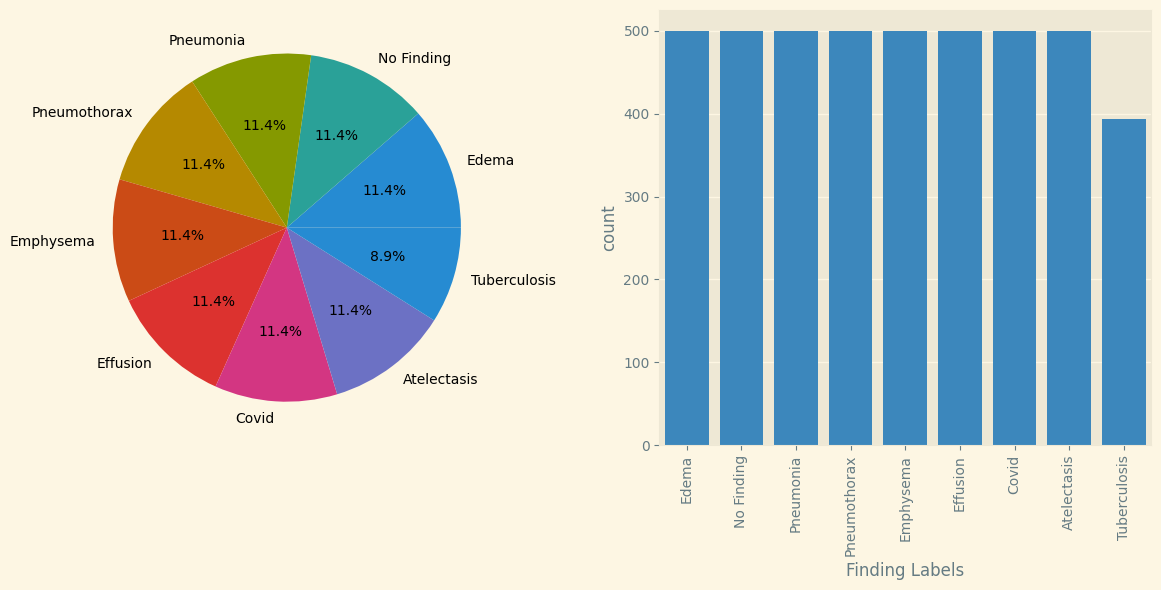

In [58]:
df = pd.read_csv('/content/rapid-cxr-dataset/metadata.csv')
tmp = {os.path.basename(x): x for x in glob(os.path.join('/content', '*','*','*', '*'))}

df['path'] = df['Image Index'].map(tmp)

label_counts = df['Finding Labels'].value_counts()
print(label_counts)

df_all = []

for label in ['Edema', 'No Finding', 'Pneumonia', 'Tuberculosis', 'Pneumothorax',  'Emphysema', 'Covid', 'Effusion', 'Atelectasis']:
    n = min(sample_num_setting, (df['Finding Labels'] == label).sum())
    df_all.append(df[df['Finding Labels'] == label].sample(n=n, random_state=42))

df = pd.concat(df_all)
df = df.reset_index(drop=True)

plt.style.use('Solarize_Light2')

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.pie(df['Finding Labels'].value_counts(), labels=label_counts.index, autopct='%.1f%%')
# plt.legend()
plt.subplot(1,2,2)
sns.countplot(x=df['Finding Labels'], order= label_counts.index)
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()


**PA vs AP**

<Figure size 1200x600 with 0 Axes>

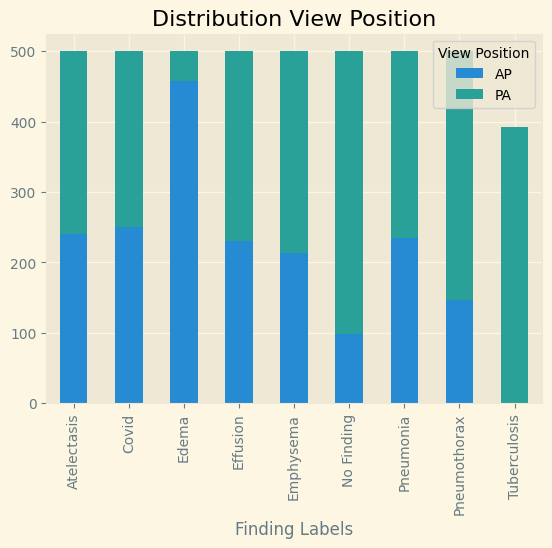

In [59]:
tmp = df.groupby(['Finding Labels','View Position']).size().unstack()
plt.figure(figsize=(12,6))
tmp.plot(kind='bar', stacked=True)
plt.title('Distribution View Position')
plt.show()

**Train & Test Split**

In [60]:
df_train, df_test = train_test_split(df, test_size=0.2, shuffle=True, random_state=42)
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

**One Hot Encoding**

In [61]:
for col in df['Finding Labels'].unique():
    df_test[col] = np.where(df_test['Finding Labels'].str.contains(col), 1.0, 0.0).astype('float32')
    df_train[col] = np.where(df_train['Finding Labels'].str.contains(col), 1.0, 0.0).astype('float32')
TARGET = df_train.columns[-9:].tolist()
TARGET

['Edema',
 'No Finding',
 'Pneumonia',
 'Tuberculosis',
 'Pneumothorax',
 'Emphysema',
 'Covid',
 'Effusion',
 'Atelectasis']

In [62]:
df_train.head()

,Image Index,Finding Labels,path,View Position,Patient ID,label_nunique,Edema,No Finding,Pneumonia,Tuberculosis,Pneumothorax,Emphysema,Covid,Effusion,Atelectasis
0,00012020_011.png,Pneumothorax,/content/rapid-cxr-dataset/lung_diseases/Pneum...,PA,12020,4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,person368_virus_748.jpeg,Pneumonia,/content/rapid-cxr-dataset/lung_diseases/Pneum...,AP,p_3141,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,00008041_000.png,No Finding,/content/rapid-cxr-dataset/lung_diseases/No Fi...,AP,8041,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,COVID19(435).jpg,Covid,/content/rapid-cxr-dataset/lung_diseases/Covid...,AP,c_363,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,CHNCXR_0656_1.png,Tuberculosis,/content/rapid-cxr-dataset/lung_diseases/Tuber...,PA,t_28,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


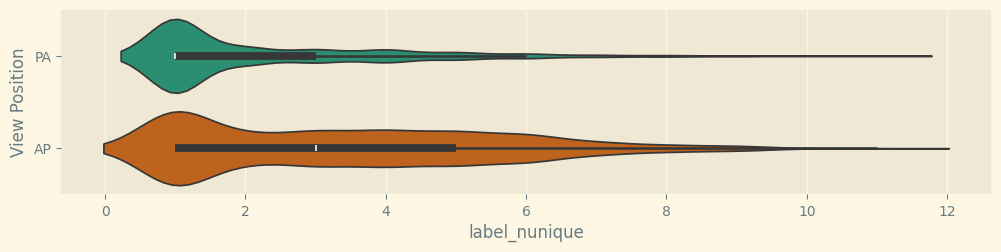

In [63]:
# @title View Position vs label_nunique

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(df_train['View Position'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(df_train, x='label_nunique', y='View Position', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

### Evaluation

In [64]:
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score, classification_report, log_loss
import seaborn as sns

def comprehensive_model_evaluation(y_actual, y_predicted, TARGET):
    # 실제 클래스와 예측 클래스 생성
    y_true = np.argmax(y_actual, axis=1)
    y_pred = np.argmax(y_predicted, axis=1)

    # 1. Classification Report
    report = classification_report(y_true, y_pred, target_names=TARGET, output_dict=True)
    df_classification = pd.DataFrame(report).transpose()
    accuracy = report['accuracy']
    macro_f1 = report['macro avg']['f1-score']

    # Precision 및 Recall 그래프
    index = np.arange(len(TARGET))
    plt.figure(figsize=(12, 3))
    plt.bar(index - 0.2, df_classification['precision'][:-3], width=0.4, label='Precision', color='skyblue')
    plt.bar(index + 0.2, df_classification['recall'][:-3], width=0.4, label='Recall', color='lightgreen')
    plt.xlabel('Class')
    plt.ylabel('Score')
    plt.title('Precision and Recall by Class')
    plt.xticks(index, TARGET)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # 2. Precision-Recall Curve
    n_classes = y_actual.shape[1]
    ap_scores = []

    plt.figure(figsize=(10, 6))
    for i in range(n_classes):
        precision, recall, _ = precision_recall_curve(y_actual[:, i], y_predicted[:, i])
        ap = average_precision_score(y_actual[:, i], y_predicted[:, i])
        ap_scores.append(ap)
        plt.plot(recall, precision, lw=2, label=f'{TARGET[i]} (AP={ap:.2f})')

    mAP = np.mean(ap_scores)

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve for Each Class')
    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.text(0.5, 0.02, f'mAP: {mAP:.4f}', ha='center', va='center', transform=plt.gca().transAxes)
    plt.tight_layout()
    plt.show()

    # 3. ROC Curve
    plt.figure(figsize=(10, 6))
    auc_scores = []
    for i, target in enumerate(TARGET):
        fpr, tpr, _ = roc_curve(y_actual[:, i], y_predicted[:, i])
        roc_auc = auc(fpr, tpr)
        auc_scores.append(roc_auc)
        plt.plot(fpr, tpr, label=f'{target} (AUC = {roc_auc:.2f})')

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.plot([0, 1], [0, 1], 'r--')
    plt.tight_layout()
    plt.show()

    # 4. 결합된 데이터프레임 생성
    df_final = pd.DataFrame({
        'Class': TARGET,
        'Precision': df_classification['precision'][:-3],
        'Recall': df_classification['recall'][:-3],
        'F1-score': df_classification['f1-score'][:-3],
        'Support': df_classification['support'][:-3],
        'AP': ap_scores,
        'AUC': auc_scores
    })

    # 결과 출력
    print(f"\nAccuracy: {accuracy:.4f}")
    print(f"Macro F1 Score: {macro_f1:.4f}")
    print(f"Mean Average Precision (mAP): {mAP:.4f}")
    print(f"Mean AUC: {np.mean(auc_scores):.4f}")

    # 2. Confusion matrix
    train_cm = confusion_matrix(y_true,y_pred, labels=[x for x in range(len(TARGET))])

    disp_all = ConfusionMatrixDisplay(confusion_matrix=train_cm,
                                      display_labels=[x for x in range(len(TARGET))])
    disp_all.plot(cmap='Blues')
    plt.title('Confusion Matrix for All Folds')
    plt.show()

    return df_final, accuracy, macro_f1, mAP, train_cm


def analyze_and_visualize_loss(y_actual, y_predicted, TARGET, n_bins=10):
    y_true = np.argmax(y_actual, axis=1)
    y_pred = np.argmax(y_predicted, axis=1)

    # Calculate Cross-Entropy Loss and ECE
    ce_loss = log_loss(y_true, y_predicted)

    confidences = np.max(y_predicted, axis=1)
    accuracies = (y_pred == y_true)

    bin_boundaries = np.linspace(0, 1, n_bins + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]

    ece = 0
    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        in_bin = (confidences > bin_lower) & (confidences <= bin_upper)
        prop_in_bin = np.mean(in_bin)
        if prop_in_bin > 0:
            accuracy_in_bin = np.mean(accuracies[in_bin])
            avg_confidence_in_bin = np.mean(confidences[in_bin])
            ece += np.abs(avg_confidence_in_bin - accuracy_in_bin) * prop_in_bin

    print(f'Cross-Entropy Loss: {ce_loss:.4f}')
    print(f'Expected Calibration Error (ECE): {ece:.4f}')

    # Visualize Loss Distribution
    loss = tf.keras.losses.categorical_crossentropy(y_actual, y_predicted)

    # 1. Distribution of Loss for Each Label
    plt.figure(figsize=(15, 3))
    plt.title('Distribution of Loss for Each Label')
    sns.boxplot(x=[TARGET[true_label] for true_label in y_true],
                y=loss.numpy(),
                order=TARGET)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    # 2. Calculate label statistics
    label_stats = pd.DataFrame({
        'Label': [TARGET[true_label] for true_label in y_true],
        'Loss': loss.numpy()
    }).groupby('Label')['Loss'].agg(['mean', 'std']).reindex(TARGET)
    label_stats.columns = ['Mean Loss', 'Std Dev']

    # 3. Mean Loss for Each Label
    plt.figure(figsize=(15, 3))
    plt.title('Mean Loss for Each Label')
    sns.barplot(x=label_stats.index, y='Mean Loss', data=label_stats, order=TARGET)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    # 4. Print top 5 and bottom 5 labels
    # print("\nTop 5 labels with highest mean loss:")
    # print(label_stats.sort_values('Mean Loss', ascending=False).head())

    # print("\nBottom 5 labels with lowest mean loss:")
    # print(label_stats.sort_values('Mean Loss', ascending=False).tail())

    return ce_loss, ece, label_stats

# <div style="padding: 25px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#A51C30"><b><span style='color:#A51C30'></span></b> <b>3. Build DataGenerator</b></div>

In [65]:
import albumentations as A
print(A.__version__)

1.4.14


In [66]:
class AugmentationPipeline:
    def __init__(self, albumentation_augs=None):
        self.albumentation_augs = A.Compose(albumentation_augs) if albumentation_augs else None

    def apply(self, images):
        if self.albumentation_augs:
            if len(images.shape) == 4:  # 배치 처리
                return np.array([self.albumentation_augs(image=img)['image'] for img in images])
            elif len(images.shape) == 3:  # 단일 이미지 처리
                return self.albumentation_augs(image=images)['image']
            else:
                raise ValueError("Unexpected input shape. Expected 3D or 4D array.")
        return images

class BatchAugmentation:
    def __init__(self, mixup_prob=0.0, cutmix_prob=0.0):
        self.mixup_prob = mixup_prob
        self.cutmix_prob = cutmix_prob

    def apply(self, X, y):
        X, y = self._apply_mixup(X, y)
        X, y = self._apply_cutmix(X, y)
        return X, y

    def _apply_mixup(self, X, y):
        if np.random.random() > self.mixup_prob:
            return X, y
        batch_size = X.shape[0]
        alpha = 0.2
        lambda_ = np.random.beta(alpha, alpha, batch_size)
        lambda_ = np.maximum(lambda_, 1 - lambda_).reshape(batch_size, 1, 1, 1)
        index = np.random.permutation(batch_size)
        X = lambda_ * X + (1 - lambda_) * X[index]
        y = lambda_.reshape(batch_size, 1) * y + (1 - lambda_).reshape(batch_size, 1) * y[index]
        return X, y

    def _apply_cutmix(self, X, y):
        if np.random.random() > self.cutmix_prob:
            return X, y
        batch_size, h, w, c = X.shape
        lambda_ = np.random.beta(1, 1)
        cut_h = int(h * np.sqrt(1 - lambda_))
        cut_w = int(w * np.sqrt(1 - lambda_))
        cx = np.random.randint(w)
        cy = np.random.randint(h)
        bbx1 = np.clip(cx - cut_w // 2, 0, w)
        bby1 = np.clip(cy - cut_h // 2, 0, h)
        bbx2 = np.clip(cx + cut_w // 2, 0, w)
        bby2 = np.clip(cy + cut_h // 2, 0, h)
        index = np.random.permutation(batch_size)
        X_cutmix = X.copy()
        X_cutmix[:, bby1:bby2, bbx1:bbx2, :] = X[index, bby1:bby2, bbx1:bbx2, :]
        lambda_ = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (w * h))
        y_cutmix = lambda_ * y + (1 - lambda_) * y[index]
        return X_cutmix, y_cutmix

In [67]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, data, batch_size=16, shuffle=False, preprocess=None, augmentation_pipeline=None, batch_augmentation=None):
        self.data = data
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.preprocess = preprocess
        self.augmentation_pipeline = augmentation_pipeline
        self.batch_augmentation = batch_augmentation
        self.on_epoch_end()
        self.clahe = cv2.createCLAHE(clipLimit=clahe_setting[0], tileGridSize=clahe_setting[1])

    def __len__(self):
        return int(np.ceil(len(self.data) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        X, y = self.__data_generation(indexes)
        if self.preprocess:X = self.preprocess(X)
        if self.augmentation_pipeline:X = self.augmentation_pipeline.apply(X)
        if self.batch_augmentation:X, y = self.batch_augmentation.apply(X, y)
        return X, y

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.data))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, indexes):
        X = np.zeros((len(indexes), 256, 256, 3), dtype='float32')
        y = np.zeros((len(indexes), len(TARGET)), dtype='float32')

        for j, i in enumerate(indexes):
            row = self.data.iloc[i]
            path = row['path']
            img = Image.open(path).convert('L')
            img = img.resize((256, 256), Image.Resampling.LANCZOS)
            img = np.array(img)
            img = self.clahe.apply(img)
            img = np.expand_dims(img, axis=-1)
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

            m = np.nanmean(img)
            img = np.nan_to_num(img, nan=m)

            X[j, :, :] = img
            y[j,] = row[TARGET]

        return X, y

# <div style="padding: 25px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#A51C30"><b><span style='color:#A51C30'></span></b> <b>4. Build ResNet Model</b></div>

In [68]:
!pip install -q git+https://github.com/qubvel/classification_models.git


  Preparing metadata (setup.py) ... done


In [69]:
# Train 데이터 Augmentation 파이프라인 (이미지 단위)
train_aug_pipeline = AugmentationPipeline(albumentation_augs=train_albumentation_augs)
train_batch_aug = None #train_batch_aug = BatchAugmentation(mixup_prob=0.2, cutmix_prob=0.2)


# Validation 데이터 Augmentation 파이프라인 (이미지 단위, 보통 최소한의 augmentation만 적용)
valid_aug_pipeline = AugmentationPipeline(albumentation_augs=valid_albumentation_augs)
valid_batch_aug = None

**Install ResNet**

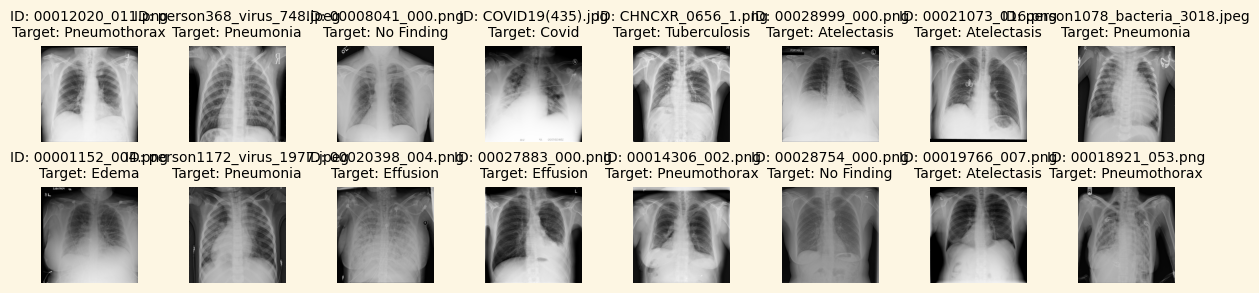

In [70]:
from classification_models.tfkeras import Classifiers

resnet18, preprocess_input = Classifiers.get('resnet18')

ROWS = 2; COLS = 8; BATCHES = 1

gen = DataGenerator(
    data=df_train,  batch_size=train_batch_setting,  shuffle=False,
    augmentation_pipeline=train_aug_pipeline,
    batch_augmentation=train_batch_aug,
    preprocess=preprocess_input
)

for i, (x,y) in enumerate(gen):
    plt.figure(figsize=(12,3))
    for j in range(ROWS):
        for k in range(COLS):
            plt.subplot(ROWS, COLS, j*COLS+k+1)
            img_id = df_train.iloc[i*16+j*COLS+k]['Image Index']
            plt.title(f'ID: {img_id}\nTarget: {df_train.iloc[i*16+j*COLS+k]["Finding Labels"]}', size=10)
            img = x[j*COLS+k,:,:,:3]
            img = img.astype('uint8')
            plt.imshow(img)
            plt.axis('off')
    plt.tight_layout()
    plt.show()
    if i==BATCHES-1: break

#### Macro F1_Score

In [71]:
def f1_score(y_true, y_pred):
    # Calculate the F1 score for each class
    f1_scores = []
    num_classes = K.int_shape(y_pred)[-1]  # (batch_size, output_dims = num_classes)

    # Get the true and predicted class indices
    y_true = K.argmax(y_true, axis=-1)
    y_pred = K.argmax(y_pred, axis=-1) # For Label Smoothing(in CCE)

    for i in range(num_classes):
        true_positives = K.sum(K.cast(tf.logical_and(K.equal(y_true, i), K.equal(y_pred, i)), dtype=tf.float32))
        possible_positives = K.sum(K.cast(K.equal(y_true, i), dtype=tf.float32))
        predicted_positives = K.sum(K.cast(K.equal(y_pred, i), dtype=tf.float32))

        recall = true_positives / (possible_positives + K.epsilon())
        precision = true_positives / (predicted_positives + K.epsilon())

        f1_score = 2 * ((precision * recall) / (precision + recall + K.epsilon()))
        f1_scores.append(f1_score)

    # Calculate the macro-average F1 score
    macro_f1_score = K.mean(tf.stack(f1_scores))
    return macro_f1_score

**ReduceLROnPleateau in Callbacks**

In [72]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

EPOCHS = epoch_setting

lr = ReduceLROnPlateau(monitor = 'val_f1_score', factor = 0.1, patience = 1, min_delta = 0.01,
                              mode='max',verbose=1)

In [73]:
def build_model():
    inp = tf.keras.layers.Input(shape=(256,256,3))
    res_model = resnet18(include_top=False, weights='imagenet', input_shape=(256,256,3))
    res_model._name = 'resnet18'

    ## Freezing Layer(10% Layer)
    for layer in res_model.layers[:len(res_model.layers)//10]:
        layer.trainable = False

    x = res_model(inp)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(len(TARGET), activation='softmax', dtype='float32')(x)

    # Compile
    model = tf.keras.Model(inputs=inp, outputs=x, name='hybrid')

    loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=label_smoothing_setting)
    opt = tf.keras.optimizers.Adam(learning_rate=learning_rate_setting)

    model.compile(loss=loss, optimizer=opt, metrics=['accuracy', f1_score])

    return model

In [74]:
from tensorflow.keras.utils import plot_model

model = build_model()
model.summary()
#plot_model(model, show_shapes=True, show_layer_names=True, expand_nested=True)

Model: "hybrid"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ functional_2 (Functional)            │ (None, 8, 8, 512)           │      11,186,889 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 9)                   │           4,617 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,191,506 (42.69 MB)

 Trainable params: 11,174,025 (42.63 MB)

 Non-trainable params: 17,481 (68.29 KB)

#### StratifiedKFold

In [75]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for i, (_, valid_index) in enumerate(skf.split(df_train, df_train['Finding Labels'])):
    df_train.loc[valid_index, 'Fold'] = i

# <div style="padding: 25px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#A51C30"><b><span style='color:#A51C30'></span></b> <b>5. TRAIN</b></div>

In [76]:
import tensorflow.keras.backend as K

all_oof = []
all_true = []
all_index = []
all_history = defaultdict(list)

for i in range(fold_num_setting): # Fold는 1개만

    print('#'*25)
    print(f'### Fold {i+1}')

    train_gen = DataGenerator(df_train[df_train['Fold'] != i],
                              batch_size=train_batch_setting,  shuffle=True,
                              augmentation_pipeline=train_aug_pipeline,
                              batch_augmentation=train_batch_aug,
                              preprocess=preprocess_input
)
    valid_gen = DataGenerator(df_train[df_train['Fold'] == i],
                              batch_size=valid_batch_setting,  shuffle=False,
                              augmentation_pipeline=valid_aug_pipeline,
                              batch_augmentation=valid_batch_aug,
                              preprocess=preprocess_input
)

    print(f'### train size {len(df_train[df_train["Fold"] != i])}, valid size {len(df_train[df_train["Fold"] == i])}')
    print('#'*25)

    K.clear_session()
    with strategy.scope():
        model = build_model()
    if LOAD_MODELS_FROM is None:
        history =  model.fit(train_gen, verbose=1,
              validation_data = valid_gen,
              epochs=EPOCHS, callbacks = [lr])
        model.save_weights(f'ResNet_{str(learning_rate_setting)}_f{i}.weights.h5')
        all_history['Train Loss'].append(history.history['loss'])
        all_history['Valid Loss'].append(history.history['val_loss'])
        all_history['Valid F1'].append(history.history['val_f1_score'])
        all_history['Train F1'].append(history.history['f1_score'])
        all_history['Valid Accuracy'].append(history.history['val_accuracy'])
        all_history['Train Accuracy'].append(history.history['accuracy'])

    else:
        model.load_weights(f'{LOAD_MODELS_FROM}ResNet_{str(learning_rate_setting)}_f{i}.weights.h5')

    oof = model.predict(valid_gen, verbose=1)
    all_oof.append(oof)
    all_true.append(df_train[df_train['Fold'] == i][TARGET].values)
    all_index.append(df_train[df_train['Fold'] == i]['path'].values)

    del model, oof, train_gen, valid_gen
    gc.collect()

all_oof = np.concatenate(all_oof)
all_true = np.concatenate(all_true)
all_index = np.concatenate(all_index)

#########################
### Fold 1
### train size 2811, valid size 703
#########################
Epoch 1/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 126s 631ms/step - accuracy: 0.3808 - f1_score: 0.3114 - loss: 2.0202 - val_accuracy: 0.3272 - val_f1_score: 0.2279 - val_loss: 2.2633 - learning_rate: 0.0010
Epoch 2/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 110s 612ms/step - accuracy: 0.5194 - f1_score: 0.4352 - loss: 1.5925 - val_accuracy: 0.3471 - val_f1_score: 0.3089 - val_loss: 1.9853 - learning_rate: 0.0010
Epoch 3/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 111s 605ms/step - accuracy: 0.5759 - f1_score: 0.4886 - loss: 1.5060 - val_accuracy: 0.5491 - val_f1_score: 0.5311 - val_loss: 1.6029 - learning_rate: 0.0010
Epoch 4/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step - accuracy: 0.6187 - f1_score: 0.5147 - loss: 1.4258
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
176/176 ━━━━━━━━━━━━━━━━━━━━ 111s 610ms/step - accuracy: 0.6186 - f1_score: 0.5147 - loss: 1.4259 - val_accuracy: 0.4737 - 

# <div style="padding: 25px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#A51C30"><b><span style='color:#A51C30'></span></b> <b>6. TRAIN-RESULT</b></div>

#### 1. 지표

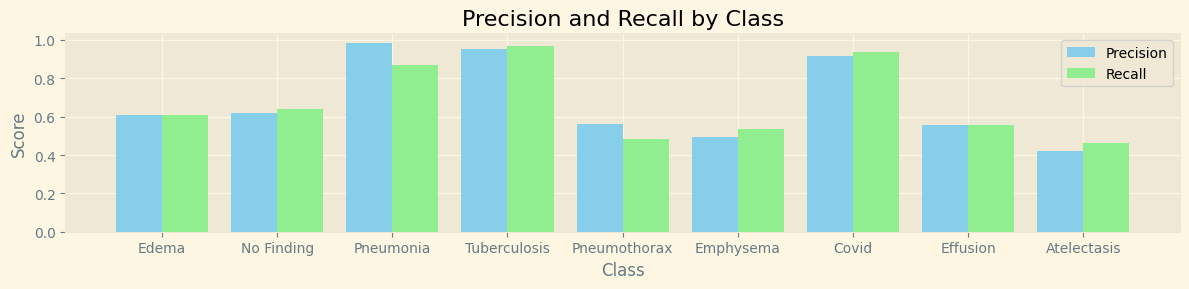

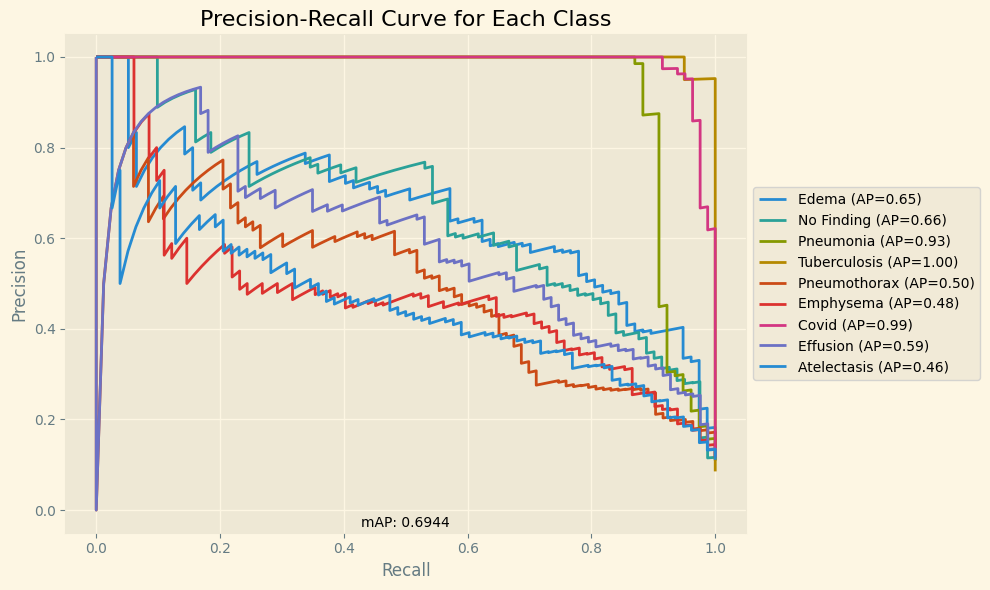

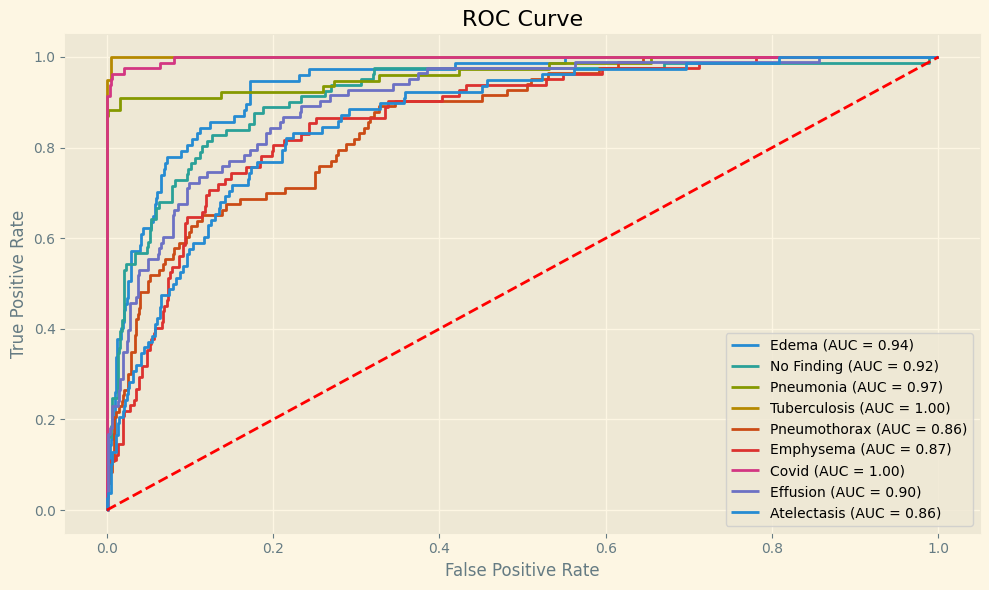


Accuracy: 0.6643
Macro F1 Score: 0.6754
Mean Average Precision (mAP): 0.6944
Mean AUC: 0.9234


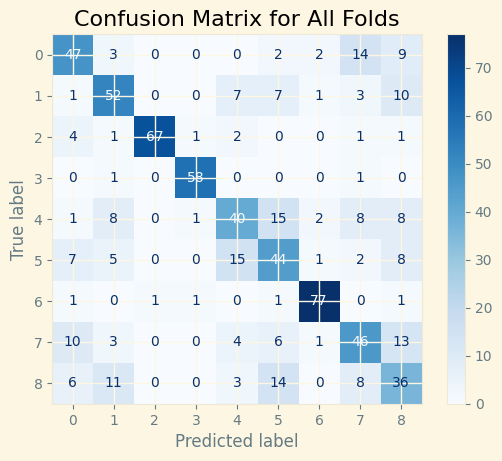

Cross-Entropy Loss: 0.9991
Expected Calibration Error (ECE): 0.0415


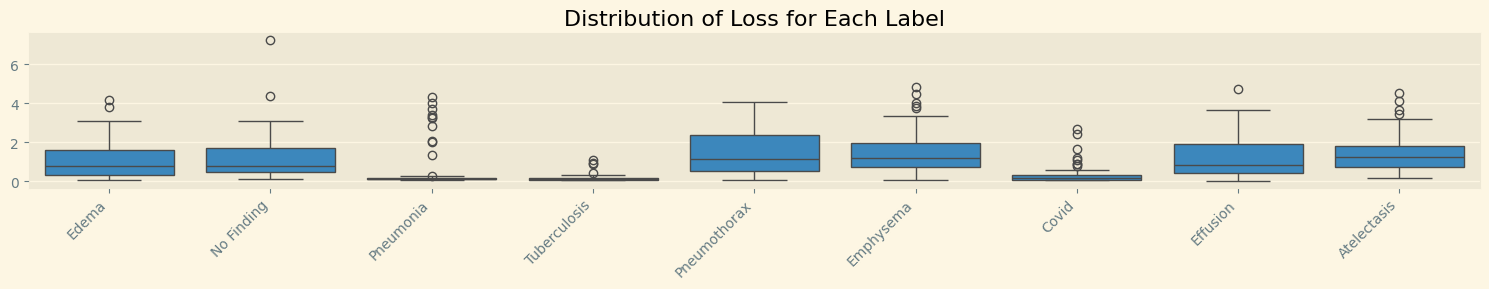

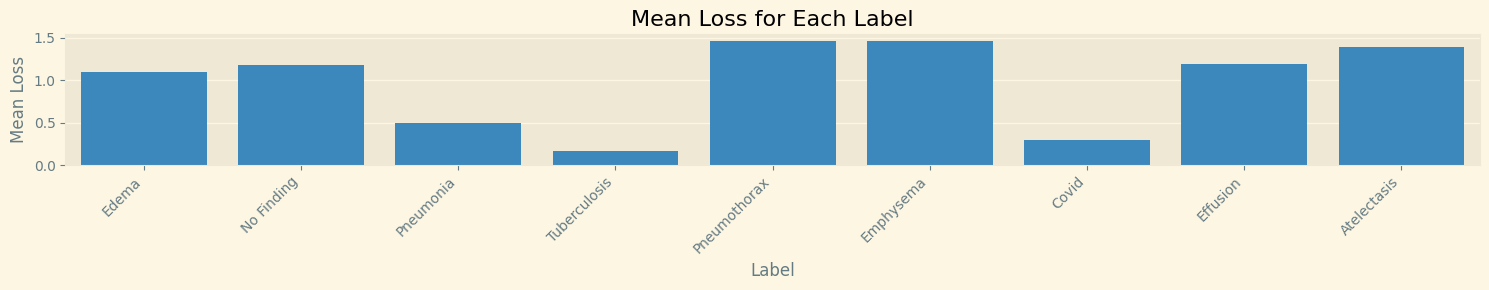

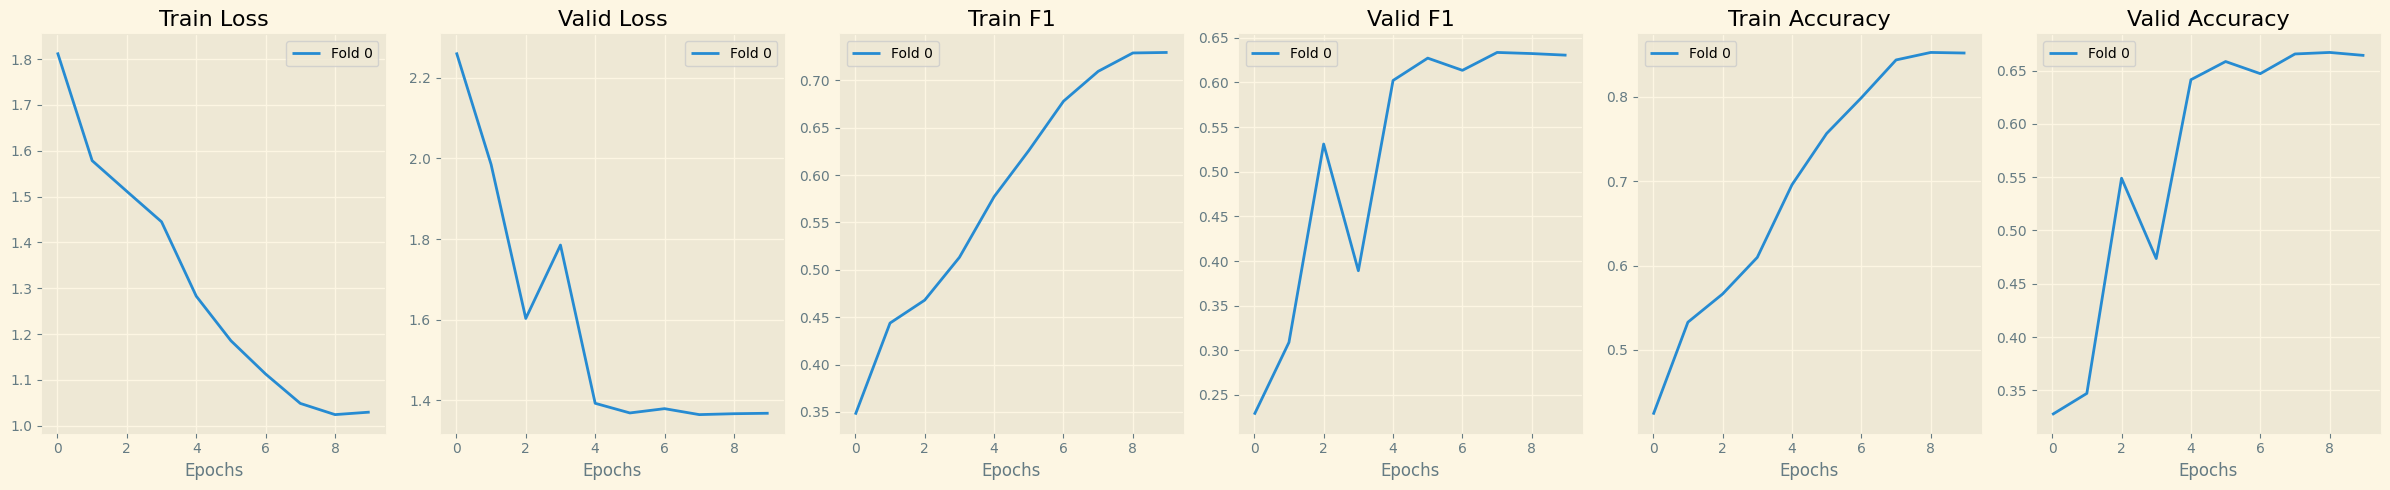

In [77]:
# 1. Accuracy, F1 score, Confusion matrix
result_train, train_accuracy, train_f1, mAP, train_cm= comprehensive_model_evaluation(all_true, all_oof, TARGET)

# 2. Loss
train_CEE,train_ECE,train_loss_stats = analyze_and_visualize_loss(all_true, all_oof, TARGET, n_bins=10)

## Train & Valid | Loss & F1 & Accuracy
if LOAD_MODELS_FROM is None:
	plt.figure(figsize=(24,5))

	metrics = ['Train Loss', 'Valid Loss', 'Train F1', 'Valid F1', 'Train Accuracy', 'Valid Accuracy']

	for idx, metric in enumerate(metrics, 1):
		plt.subplot(1, 6, idx)
		plt.title(metric)
		for fold, i in enumerate(all_history[metric]):
			plt.plot(i, label=f'Fold {fold}')
		plt.xlabel('Epochs')
		plt.legend()

	plt.tight_layout()
	plt.show()
history_train_df = pd.DataFrame(all_history)
history_train_df.index.name = 'Fold'
history_train_df = history_train_df.applymap(lambda x: [f'{i:.3f}' for i in x] if isinstance(x, list) else x)

# <div style="padding: 25px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#A51C30"><b><span style='color:#A51C30'></span></b> <b>7. TEST</b></div>

In [82]:
preds = []
model = build_model()

test_gen = DataGenerator(df_test,
                              batch_size=test_batch_setting,  shuffle=False,
                              augmentation_pipeline=valid_aug_pipeline,
                              batch_augmentation=valid_batch_aug,
                              preprocess=preprocess_input
)


for i in range(fold_num_setting):
	print(f'Fold {i+1}')
	if LOAD_MODELS_FROM:
		model.load_weights(f'{LOAD_MODELS_FROM}ResNet_{str(learning_rate_setting)}_f{i}.weights.h5')
	else:
		model.load_weights(f'ResNet_{str(learning_rate_setting)}_f{i}.weights.h5')


	pred = model.predict(test_gen, verbose=1)
	preds.append(pred)
pred_res = np.mean(preds,axis=0)

Fold 1
14/14 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step


# <div style="padding: 25px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#A51C30"><b><span style='color:#A51C30'></span></b> <b>8. TEST-RESULT</b></div>

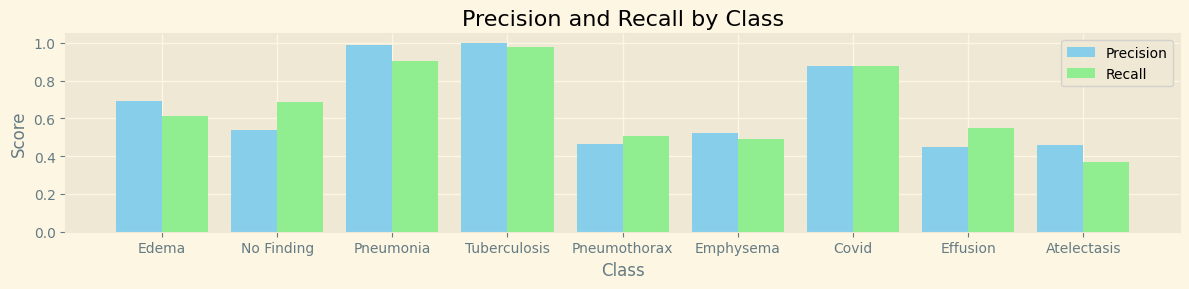

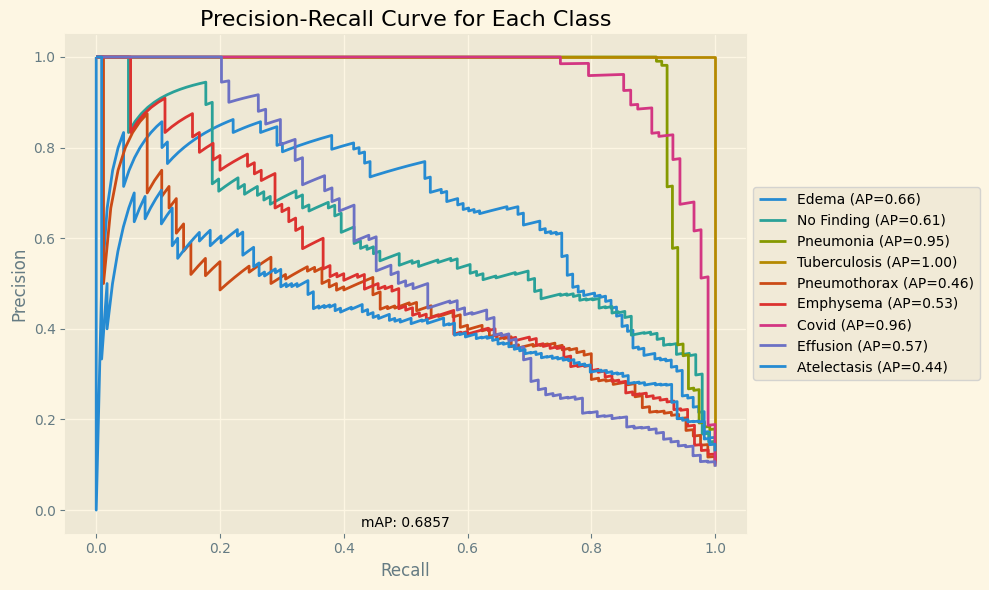

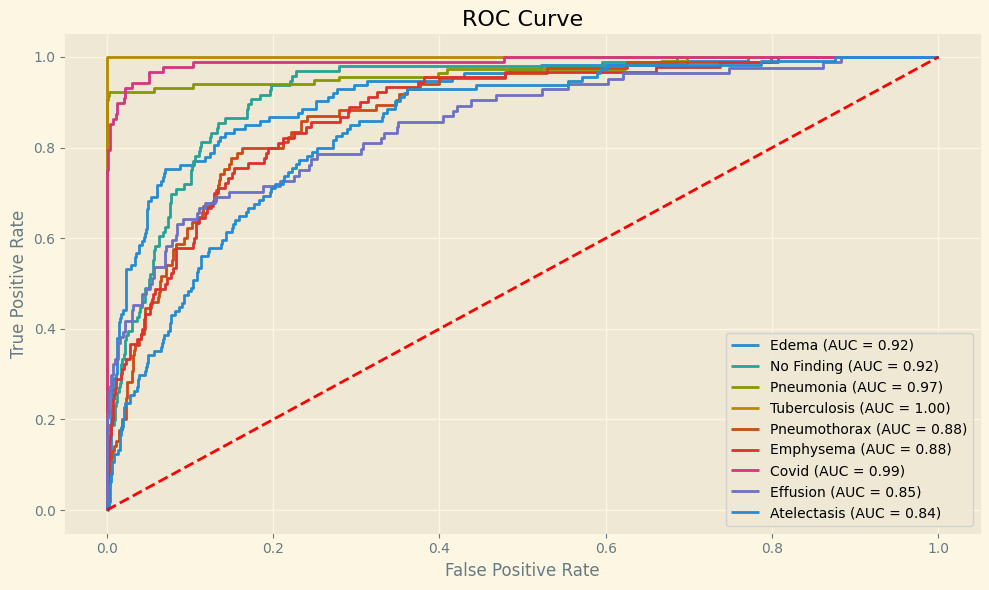


Accuracy: 0.6633
Macro F1 Score: 0.6613
Mean Average Precision (mAP): 0.6857
Mean AUC: 0.9175


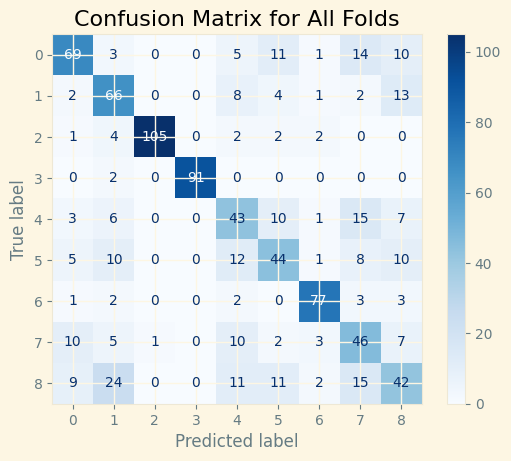

Cross-Entropy Loss: 1.0167
Expected Calibration Error (ECE): 0.0574


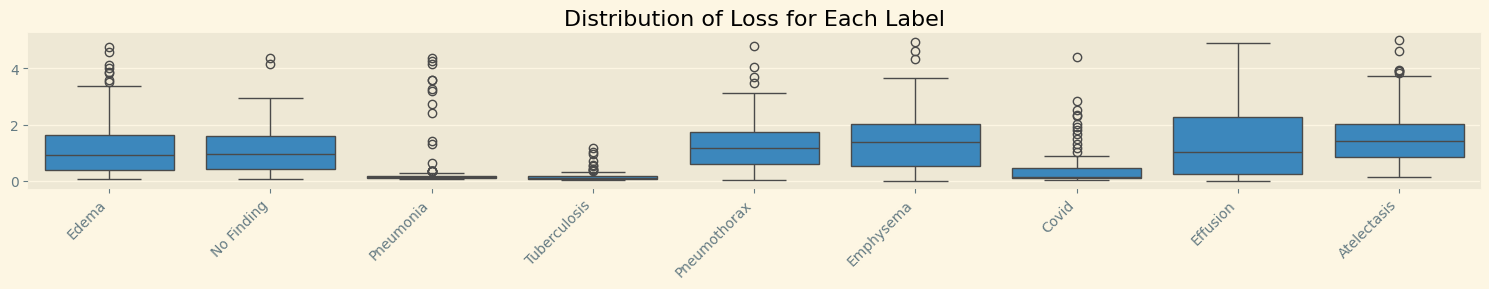

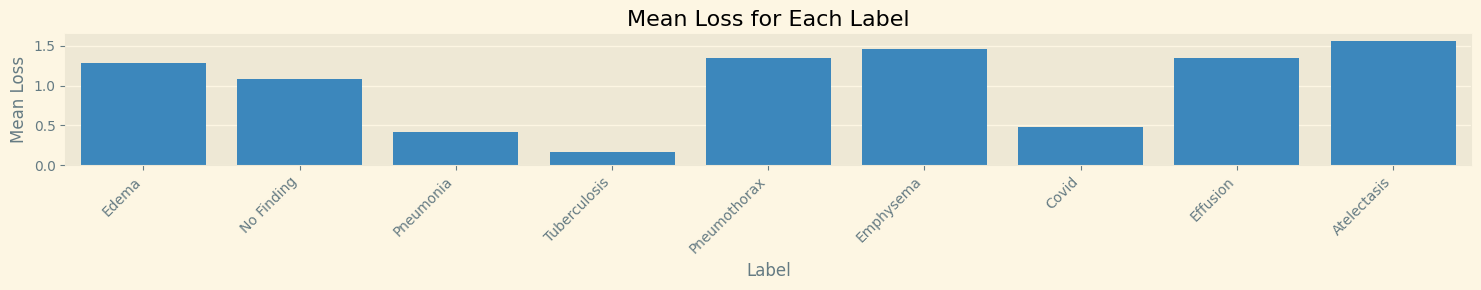

In [83]:
# 지표 1
result_test, test_accuracy, test_f1, test_mAP,test_cm= comprehensive_model_evaluation(df_test[TARGET].values, pred_res, TARGET)

# 2. Loss
test_CEE,test_ECE,test_loss_stats = analyze_and_visualize_loss(df_test[TARGET].values, pred_res, TARGET, n_bins=10)



# <div style="padding: 25px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#A51C30"><b><span style='color:#A51C30'></span></b> <b>9. Overall Result</b></div>

In [84]:
print(f'train_accuracy: {train_accuracy:.4f}')
print(f'train_f1: {train_f1:.4f}')
print(f'test_accuracy: {test_accuracy:.4f}')
print(f'test f1: {test_f1:.4f}')

print()
print(f'mAP: {mAP:.4f}')

print()
print(f'train CEE: {train_CEE:.4f}')
print(f'train ECE: {train_ECE:.4f}')
print(f'test CEE: {test_CEE:.4f}')
print(f'test_ECE: {test_ECE:.4f}')


print(f'\n{test_accuracy:.4f} | {test_f1:.4f} | {test_CEE:.4f} | {test_ECE:.4f} | {train_accuracy:.4f} | {train_f1:.4f} | {train_CEE:.4f} | {train_ECE:.4f}')


LEARNING RATE: 0.001

train_accuracy: 0.6643
train_f1: 0.6754
test_accuracy: 0.6633
test f1: 0.6613

mAP: 0.6944

train CEE: 0.9991
train ECE: 0.0415
test CEE: 1.0167
test_ECE: 0.0574

0.6633 | 0.6613 | 1.0167 | 0.0574 | 0.6643 | 0.6754 | 0.9991 | 0.0415


In [85]:
from datetime import datetime

print(*TARGET,sep=', ')
print()
for i,x in experiment_setting.items():
    print(f'{i}: {x}')

print()

current_time = datetime.now()
print(f'완료 시간: {current_time.strftime("%Y-%m-%d %H:%M:%S")}')

Edema, No Finding, Pneumonia, Tuberculosis, Pneumothorax, Emphysema, Covid, Effusion, Atelectasis

sample_num_setting: 500
epoch_setting: 10
label_smoothing_setting: 0.15
learning_rate_setting: 0.001
train_batch_setting: 16
valid_batch_setting: 32
test_batch_setting: 64
fold_num_setting: 1

완료 시간: 2024-09-04 07:56:23
